In [1]:
import sys
import os

root_dir = os.path.dirname(os.getcwd())
sys.path.append(root_dir)

In [2]:
import numpy as np
import pandas as pd
from typing import List, Dict
import string
from datetime import datetime
import matplotlib.pyplot as plt
from ambrosia.splitter import Splitter
from ambrosia.tester import test


Your CPU supports instructions that this binary was not compiled to use: AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib


# Генерация датасета

In [3]:
class Dataset:
    def __init__(
            self,
            random_seed: int = None
        ) -> None:
        self.group_names_ = list(string.ascii_uppercase[:10])
        self.random_seed = random_seed

    def generate(
            self,
            binary_metrics: List[str] = None,
            continuous_metrics: List[str] = None,
            dataframe_size: int = 1000,
            date_num: int = 0,
            group_num: int = 0,
        ) -> pd.DataFrame:
        
        if self.random_seed is not None:
            np.random.seed(self.random_seed)

        start_date = datetime(2023, np.random.randint(1, 12), np.random.randint(1, 31))
        date_range = pd.date_range(start_date, start_date + pd.Timedelta(f'{date_num - 1}d'))
        
        user_ids = np.random.choice(np.arange(10, 100000), size=dataframe_size * (date_num + 1))
        
        if date_num != 0:
            pairs = [(date, user) for user in user_ids for date in date_range][:dataframe_size]
            data = {
                'date': [elem[0] for elem in pairs],
                'user_id': [elem[1] for elem in pairs],
            }
        else:
            data = {
                'user_id': user_ids
            }

        for bin_metric in binary_metrics:
            random_convertion = round(np.random.random(), 2)
            converted_cnt = int(random_convertion * dataframe_size)
            data.update(self._generate_list_with_need_convertion(bin_metric, converted_cnt, dataframe_size))
        
        for cont_metric in continuous_metrics:
            data.update(self._generate_continuous_metrics(cont_metric, dataframe_size))
        
        data_df = pd.DataFrame(data)

        if group_num != 0:
            users = pd.DataFrame(data_df['user_id'].unique(), columns=['user_id'])
            splitter = Splitter(
                dataframe=users, 
                id_column='user_id'
            )
            split_result = splitter.run(
                method='hash',
                salt=str(self.random_seed),
                groups_size=int(users.shape[0] / group_num),
                groups_number=group_num
            )
            data_df = data_df.merge(split_result, on='user_id')

        return data_df

    def _generate_list_with_need_convertion(self, metric_name: str, converted_cnt: int, all_cnt: int) -> Dict[str, np.array]:
        """
        Генерируем массив с количеством сконвертировавшихся юнитов
        :param converted_cnt: количество сконвертировавшихся юнитов
        :param all_cnt: общее количество юнитов
        :return: массив из 0 и 1, где количество 1 равно converted_cnt, количество 0 - all_cnt - converted_cnt
        """
        assert converted_cnt <= all_cnt, 'Количество сконвертировавихся должно быть меньше, чем общее количество'
        x = np.array([*([1] * converted_cnt), *([0] * (all_cnt - converted_cnt))])
        np.random.shuffle(x)
        return {metric_name: x}

    def _generate_continuous_metrics(self, metric_name: str, size: int) -> Dict[str, np.array]:
        mu = np.random.randint(10, 100)
        std = np.random.randint(3, 20)
        return {metric_name: np.random.normal(loc=mu, scale=std, size=size)}

In [4]:
binary_metrics = ['convertion_1', 'convertion_2']
continuous_metrics = ['cont_metric_1', 'cont_metric_2']


dataset = Dataset().generate(
    binary_metrics=binary_metrics,
    continuous_metrics=continuous_metrics,
    group_num=2,
    date_num=14
)
dataset

,date,user_id,convertion_1,convertion_2,cont_metric_1,cont_metric_2,group
0,2023-06-18,48856,1,1,80.457464,49.425583,B
1,2023-06-19,48856,0,0,93.394823,72.306685,B
2,2023-06-20,48856,0,0,79.583790,74.749729,B
3,2023-06-21,48856,1,0,92.556695,90.911372,B
4,2023-06-22,48856,1,1,82.722587,85.535543,B
...,...,...,...,...,...,...,...
995,2023-06-19,22361,0,0,94.615436,81.219643,B
996,2023-06-20,22361,1,0,97.696364,66.478360,B
997,2023-06-21,22361,0,1,70.769562,79.041635,B
998,2023-06-22,22361,1,0,97.295484,79.478897,B


In [11]:
metrics = {
    'convertion_1': ['sum'],
    'convertion_2': ['mean'],
    'cont_metric_1': ['mean', 'std'],
    'user_id': ['nunique']
}

res = dataset.groupby(
    ['date'],
    as_index=False
).agg(metrics)

res.columns = [f'{col[0]}_{col[1]}' if col[1] else col[0] for col in res.columns]

res

,date,convertion_1_sum,convertion_2_mean,cont_metric_1_mean,cont_metric_1_std,user_id_nunique
0,2023-06-18,53,0.319444,88.151346,9.341051,72
1,2023-06-19,61,0.277778,88.708026,8.756724,72
2,2023-06-20,56,0.291667,87.152208,8.966388,72
3,2023-06-21,54,0.333333,87.723592,8.807123,72
4,2023-06-22,60,0.388889,89.529238,9.492131,72
5,2023-06-23,55,0.305556,87.625448,10.323939,72
6,2023-06-24,52,0.309859,86.047912,8.891478,71
7,2023-06-25,63,0.225352,87.259984,8.086801,71
8,2023-06-26,59,0.323944,87.484238,10.093254,71
9,2023-06-27,58,0.352113,88.251796,8.258428,71


In [21]:


sorted_df = dataset.sort_values(by='date').copy()

# Расчет кумулятивного стандартного отклонения метрики по группе теста на каждый день
sorted_df['cumulative_std'] = sorted_df.groupby(['date', 'group'])['convertion_1'].transform(lambda x: x.expanding().std())

print(sorted_df)


          date  user_id  convertion_1  convertion_2  cont_metric_1  \
0   2023-06-18    48856             1             1      80.457464   
672 2023-06-18    59320             1             1      95.718527   
686 2023-06-18    64007             0             0      73.660538   
210 2023-06-18    33153             0             0      78.623919   
700 2023-06-18    51900             1             0      86.686748   
..         ...      ...           ...           ...            ...   
909 2023-07-01     4264             1             1      96.087680   
251 2023-07-01    73105             0             0      76.535505   
615 2023-07-01    31379             1             1      82.490557   
237 2023-07-01    91361             1             0      79.611461   
559 2023-07-01    20081             1             1      83.257629   

     cont_metric_2 group  cumulative_std  
0        49.425583     B             NaN  
672     111.542287     B        0.000000  
686      67.239350     A      

In [30]:
copy_df = dataset[['date', 'user_id', 'group', 'cont_metric_1']].copy().sort_values(by=['date'], ignore_index=True)

copy_df['cont_metric_1_sum_1'] = copy_df.groupby('date')['cont_metric_1'].transform(lambda x: x.expanding().sum())

copy_df[copy_df['date'] == '2023-06-19']

,date,user_id,group,cont_metric_1,cont_metric_1_sum_1
72,2023-06-19,19740,B,78.379419,78.379419
73,2023-06-19,31379,B,99.979133,178.358552
74,2023-06-19,2634,B,101.045396,279.403948
75,2023-06-19,59090,A,86.291549,365.695497
76,2023-06-19,78224,A,88.212290,453.907787
...,...,...,...,...,...
139,2023-06-19,72119,B,76.325086,6018.059589
140,2023-06-19,48856,B,93.394823,6111.454412
141,2023-06-19,51664,A,102.043523,6213.497934
142,2023-06-19,33906,B,89.818428,6303.316362


In [16]:
dataset.groupby(
    'date',
    as_index=False
)['convertion_1']

,convertion_1
0,1
1,0
2,0
3,1
4,1
...,...
995,61
996,56
997,54
998,60


In [32]:
pd.read_json('sample_dataset.json')

,date,user_id,convertion_1,convertion_2,cont_metric_1,cont_metric_2,group
0,2023-11-22,22910,0,1,26.967993,55.497232,A
1,2023-11-11,10228,1,1,25.319604,34.148835,A
2,2023-11-11,66147,0,0,30.921624,69.311181,B
3,2023-11-13,85620,0,1,17.444558,64.651607,A
4,2023-11-15,42646,1,0,39.094049,58.228649,A
5,2023-11-11,64731,0,1,24.667907,40.631499,A
6,2023-11-21,96106,1,1,63.550678,54.173481,A
7,2023-11-13,46741,1,0,36.158356,34.813497,A
8,2023-11-16,73844,1,1,30.781159,52.075047,B
9,2023-11-16,51503,1,1,45.798057,49.795453,A


# Визуализации

In [18]:
AVAILABLE_METRICS_TYPES = ['continuous', 'binary']

def calc_test_results(
    data: pd.DataFrame,
    group_column: str,
    metrics: Dict[str, List[str]],
    config: Dict,
    as_table: bool = True
) -> pd.DataFrame:
    """
    Calculate test results of each group

    Args:
        data (pd.DataFrame): DataFrame with metrics per user and groups
        group_column (str): Column where groups contains
        metrics (Dict[str, List[str]]): dictionary with metric type and metric names. Available types: ['continuous', 'binary']
        Example:
        {
            'binary': ['convertion_1', 'convertion_2'],
            'continuous': ['avg_price']
        }
        config (Dict): config with test params

    Returns:
        pd.DataFrame: DataFrame with test results
    """
    if 'binary' in metrics:
        binary_results = test(
            dataframe=data,
            metrics=metrics['binary'],
            column_groups=group_column,
            first_type_errors=config['first_type_errors'],
            correction_method=None,
            as_table=False
        )
    else:
        binary_results = []
    
    if 'continuous' in metrics:

        continuous_criterion = config['criterion']
        mapping = {
            'Бутстрап': {'method': 'empiric'},
            'Т-тест': {'criterion':'ttest'},
            'Манн-Уитни': {'criterion':'mw'}
        }

        continuous_results = test(
            dataframe=data,
            metrics=metrics['continuous'],
            column_groups=group_column,
            first_type_errors=config['first_type_errors'],
            as_table=False,
            correction_method=None,
            **mapping[continuous_criterion]
        )
    else:
        continuous_results = []
    
    if len(binary_results) == 0 and len(continuous_results) == 0:
        raise ValueError(f'Названия метрик не переданы или переданы некорректные типы. Список корректных типов: {AVAILABLE_METRICS_TYPES}')
    
    test_results = [*binary_results, *continuous_results]

    for test_result in test_results:
        test_result['mean in A'] = data[data[group_column] == test_result['group A label']][test_result['metric name']].mean()
        test_result['num in A'] = data[data[group_column] == test_result['group A label']].shape[0]
    
        test_result['mean in B'] = data[data[group_column] == test_result['group B label']][test_result['metric name']].mean()
        test_result['num in B'] = data[data[group_column] == test_result['group B label']].shape[0]

        test_result['is_success'] = test_result['pvalue'] < test_result['first_type_error']

    if as_table:
        return pd.DataFrame(test_results)
    else:
        return test_results


In [44]:
def show_plot(
        df: pd.DataFrame,
        date_col: str,
        group_col: str,        
        metrics_for_plot: List[str],
        title: str
) -> None:
    """
    Vizualize plots

    Args:
        df (pd.DataFrame): dataframe with test result and date
        date_col (str): date column name
        group_col (str): group column name
        metrics_for_plot (List[str]): names of metric for plot
        title (str): title of all graphts
    """
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:10]
    with plt.style.context('seaborn-v0_8'):
        num_plots = len(metrics_for_plot)
        fig, axs = plt.subplots(
            num_plots, 1, sharex=True, constrained_layout=True, figsize=(9, 3 * num_plots)
        )
        group_names = df[group_col].unique()
        for i, metric_name in enumerate(metrics_for_plot):
            for group_num, group in enumerate(group_names):
                df_for_plot = df[df[group_col] == group]
                axs[i].plot(df_for_plot[date_col], df_for_plot[metric_name], color=colors[group_num], label=group)
                axs[i].xaxis_date()
                axs[i].set_title(metric_name)
                axs[i].legend(loc='upper right')
                plt.xlabel("Date")
        plt.suptitle(title)
        plt.show()



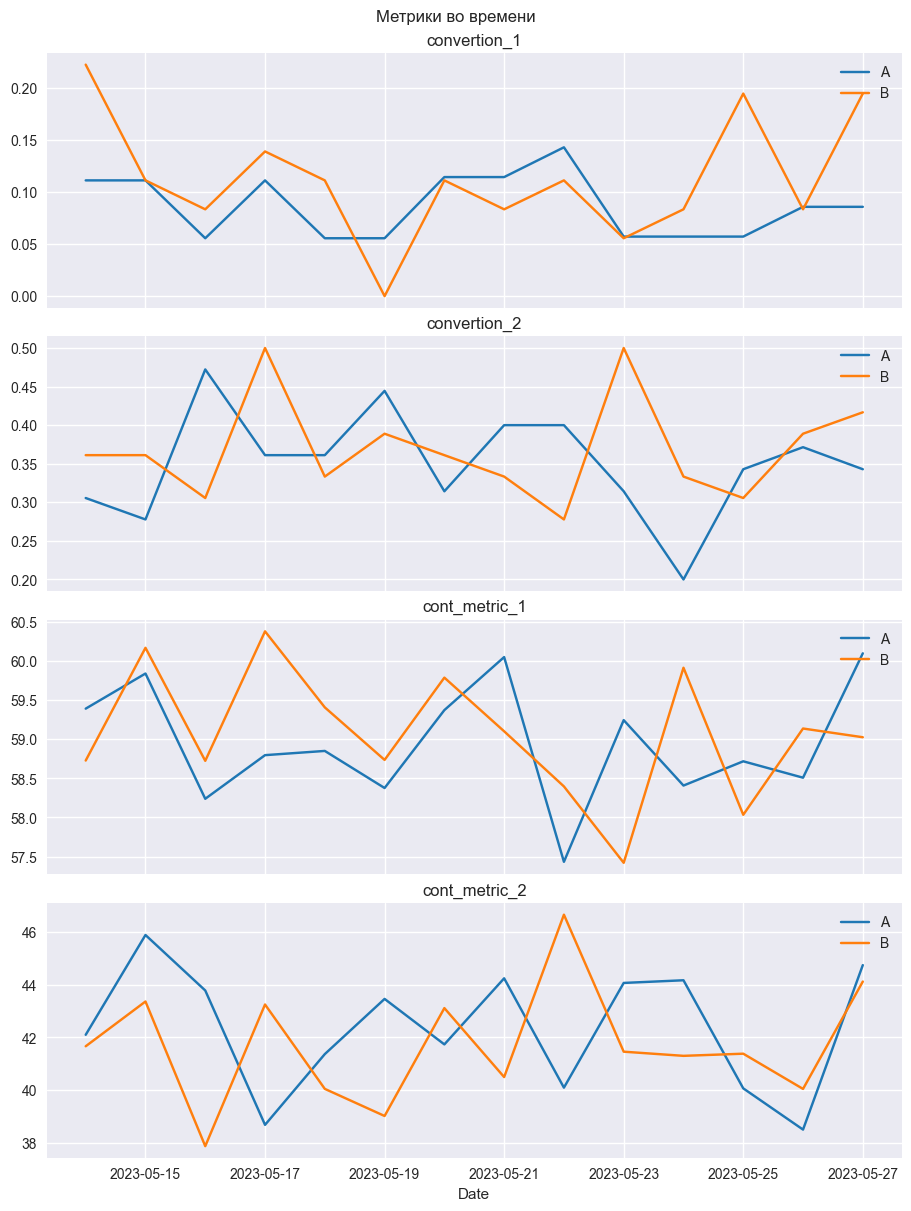

In [45]:
# Рассчитываем значение метрики во времени

all_metrics = [*binary_metrics, *continuous_metrics]
calc_metrics = dataset.groupby(['date', 'group'], as_index=False)[all_metrics].mean()

show_plot(
    calc_metrics, 
    'date',
    'group',
    all_metrics,
    'Метрики во времени'
)

In [46]:
def calculate_cum_metrics(
        df: pd.DataFrame,
        date_col: str,
        group_col: str,
        metrics: List[str],
) -> pd.DataFrame:
    df = df.copy()
    df.sort_values(by=[date_col], ignore_index=True, inplace=True)

    cum_df = pd.DataFrame()

    for metric in metrics:
        grouped_df = df.groupby([date_col, group_col]) \
                        .agg({metric: 'sum', group_col: 'size'}) \
                        .rename(columns={group_col: 'cnt', metric: 'metric'}) \
                        .reset_index()
        grouped_df['cum_sum'] = grouped_df.groupby(group_col)['metric'].cumsum()
        grouped_df['cum_cnt'] = grouped_df.groupby(group_col)['cnt'].cumsum()
        grouped_df[metric] = grouped_df['cum_sum'] / grouped_df['cum_cnt']
        grouped_df = grouped_df[[date_col, group_col, metric]]
        if cum_df.empty:
            cum_df = pd.concat([cum_df, grouped_df], axis=0)
        else:
            cum_df = cum_df.merge(grouped_df, on=[date_col, group_col])
    return cum_df



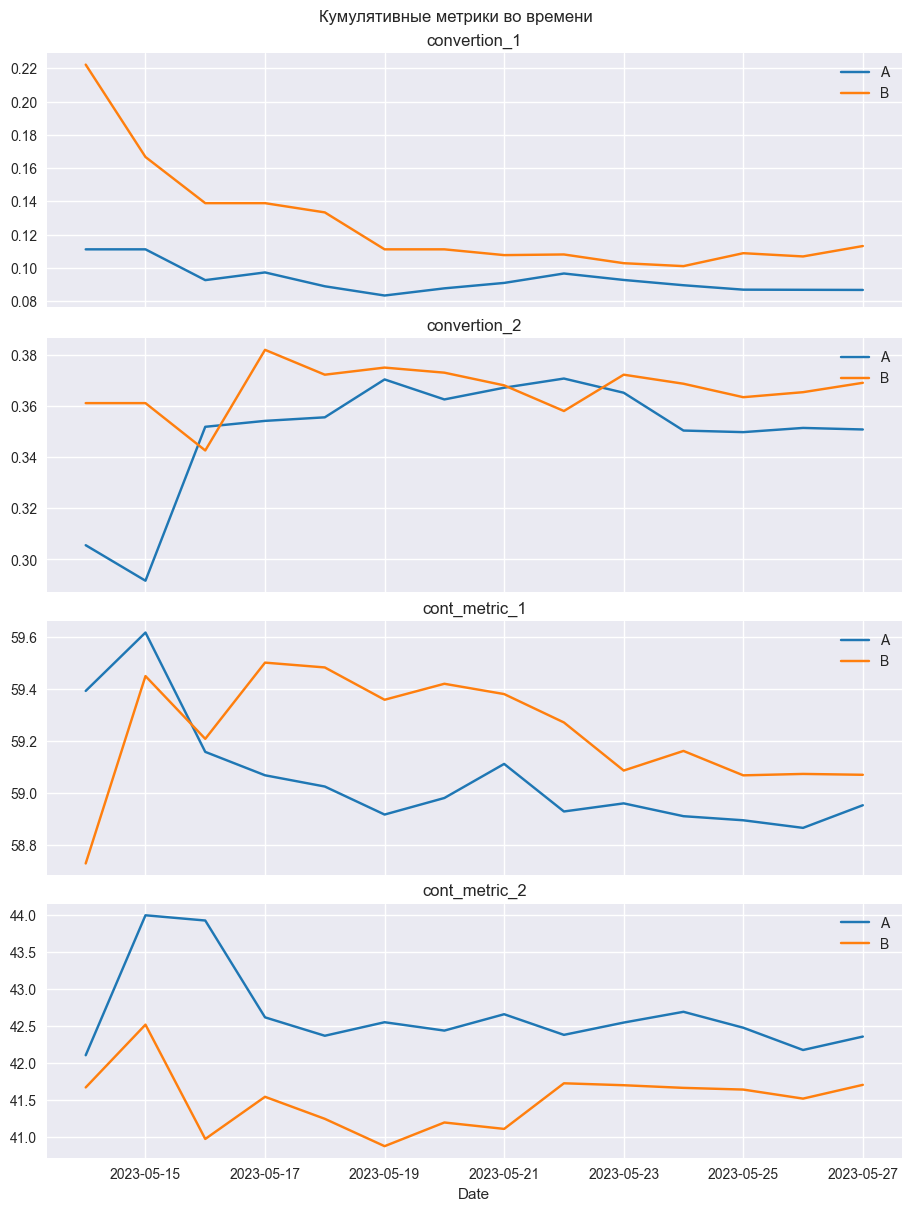

In [47]:
all_metrics = [*binary_metrics, *continuous_metrics]

cum_metrics = calculate_cum_metrics(
    dataset,
    'date',
    'group',
    all_metrics
)

show_plot(
    cum_metrics, 
    'date',
    'group',
    all_metrics,
    'Кумулятивные метрики во времени'
)

In [11]:
a = {1: [2, 3], 3:[2, 3]}

[i for elem in a.values() for i in elem]

[2, 3, 2, 3]

In [71]:
#  Рассчитываем кумулятивно pvalue во времени

def calc_pvalue(
    df: pd.DataFrame,
    date_col: str,
    group_col: str,
    user_col: str,
    metrics: Dict[str, List[str]],
    test_config: Dict
) -> pd.DataFrame:
    """
    Calculate pvalue per days

    Args:
        df (pd.DataFrame): dataframe with metrics values in test period, group and users
        date_col (str): date column name 
        group_col (str): group column name 
        user_col (str): user column name 
        metrics (Dict[str, List[str]]): dictionary with metric type and metric names. Available types: ['continuous', 'binary']
        Example:
        {
            'binary': ['convertion_1', 'convertion_2'],
            'continuous': ['avg_price']
        }
        test_config (Dict): config with test params

    Returns:
        pd.DataFrame: Dataframe with days and pvalue per each metric
    """
    dates = df[date_col].unique()
    dates = dates[dates.argsort()]
    user_per_group = df[[user_col, group_col]].drop_duplicates()
    pvalue_per_days = []
    
    for date in dates:
        df_per_date = df[df[date_col] <= date].copy()

        if 'binary' in metrics:
            binary_user_metrics = df_per_date.groupby(user_col, as_index=False)[metrics['binary']].max()
        
        if 'continuous' in metrics:
            continuous_user_metrics = df_per_date.groupby(user_col, as_index=False)[metrics['continuous']].sum()
        
        user_metrics = continuous_user_metrics.merge(binary_user_metrics, on=user_col).merge(user_per_group, on=user_col)
        test_result = calc_test_results(
            data=user_metrics,
            group_column=group_col,
            metrics=metrics,
            config=test_config,
            as_table=False
        )
        metrics_pvalue = {res['metric name']: res['pvalue'] for res in test_result}
        pvalue_per_days.append(
            {
                date_col: date,
                **metrics_pvalue
            }
        )
    return pd.DataFrame(pvalue_per_days)


def plot_pvalues(
    data: pd.DataFrame,
    date_col: str,
    metrics: List[str],
    pvalue_treshold: float = 0.05
) -> None:
    with plt.style.context('seaborn-v0_8'):
        num_plots = len(metrics)
        fig, axs = plt.subplots(
            num_plots, 1, sharex=True, constrained_layout=True, figsize=(9, 3 * num_plots)
        )
        for i, metric_name in enumerate(metrics):
            df_for_plot = data[[date_col, metric_name]]
            test_significant_mask = df_for_plot[metric_name] < pvalue_treshold
            axs[i].plot(df_for_plot[date_col], df_for_plot[metric_name])
            axs[i].scatter(df_for_plot[test_significant_mask][date_col], df_for_plot[test_significant_mask][metric_name], color='red')
            axs[i].axhline(pvalue_treshold, color='grey', linestyle='--', label=f'pvalue={pvalue_treshold}')
            axs[i].xaxis_date()
            axs[i].legend(loc='upper right')
            axs[i].set_title(metric_name)
            plt.xlabel("Date")
        plt.suptitle('Pvalue по дням')
        plt.show()


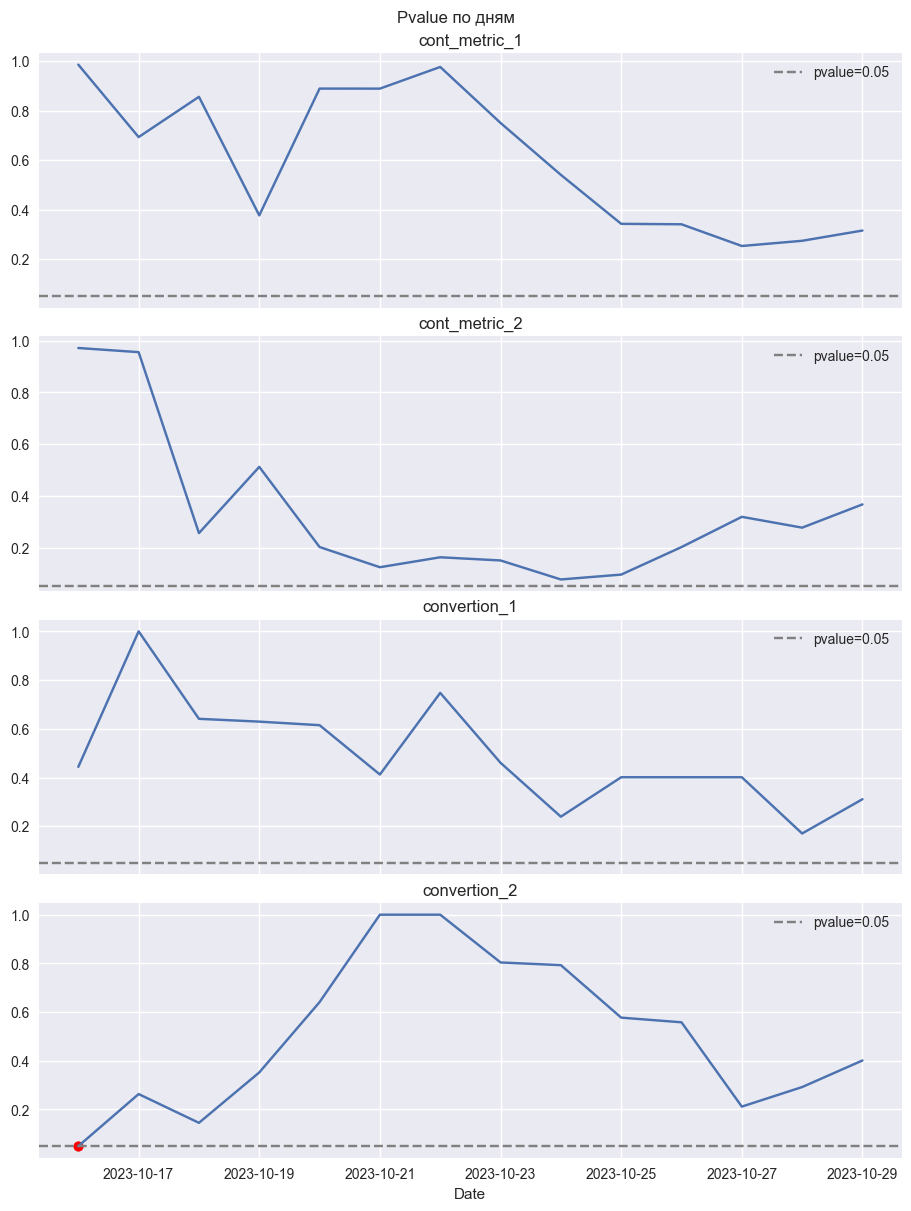

In [72]:
pvalues = calc_pvalue(
    dataset,
    'date',
    'group',
    'user_id',
    {
        'continuous': continuous_metrics,
        'binary': binary_metrics
    },
    {
        'first_type_errors': [0.05],
        'criterion': 'Т-тест'
    }
)

plot_pvalues(
    pvalues,
    'date',
    [*continuous_metrics, *binary_metrics],
)


In [73]:
# Рассчитываем эффект по дням и его ДИ

def calc_effect(
    df: pd.DataFrame,
    date_col: str,
    group_col: str,
    user_col: str,
    metrics: Dict[str, List[str]],
    test_config: Dict,
):
    
    dates = df[date_col].unique()
    dates = dates[dates.argsort()]
    user_per_group = df[[user_col, group_col]].drop_duplicates()
    effect_per_days = []
    
    for date in dates:
        df_per_date = df[df[date_col] <= date].copy()

        if 'binary' in metrics:
            binary_user_metrics = df_per_date.groupby(user_col, as_index=False)[metrics['binary']].max()
        
        if 'continuous' in metrics:
            continuous_user_metrics = df_per_date.groupby(user_col, as_index=False)[metrics['continuous']].sum()
        
        user_metrics = continuous_user_metrics.merge(binary_user_metrics, on=user_col).merge(user_per_group, on=user_col)
        test_result = calc_test_results(
            data=user_metrics,
            group_column=group_col,
            metrics=metrics,
            config=test_config,
            as_table=False
        )
        effects = {}
        for res in test_result:
            ci = res['confidence_interval']
            metric_name = res['metric name']
            effects[f"{metric_name}_effect"] = res['effect']
            effects[f"{metric_name}_low_ci"] = ci[0]
            effects[f"{metric_name}_high_ci"] = ci[1]
        effect_per_days.append(
            {
                date_col: date,
                **effects
            }
        )
    return pd.DataFrame(effect_per_days)


def plot_effect(
    data: pd.DataFrame,
    date_col: str,
    metrics: List[str],
) -> None:
    with plt.style.context('seaborn-v0_8'):
        num_plots = len(metrics)
        fig, axs = plt.subplots(
            num_plots, 1, sharex=True, constrained_layout=True, figsize=(9, 3 * num_plots)
        )
        for i, metric_name in enumerate(metrics):
            df_for_plot = data[[date_col, f"{metric_name}_effect", f"{metric_name}_low_ci", f"{metric_name}_high_ci"]]
            axs[i].plot(df_for_plot[date_col], df_for_plot[f"{metric_name}_effect"], label='effect')
            axs[i].fill_between(df_for_plot[date_col], df_for_plot[f"{metric_name}_low_ci"], df_for_plot[f"{metric_name}_high_ci"], 
                                label='CI', alpha=0.3, color='gray')
            axs[i].xaxis_date()
            axs[i].legend(loc='upper right')
            axs[i].set_title(metric_name)
            plt.xlabel("Date")
        plt.suptitle('Значение эффекта по дням')
        plt.show()

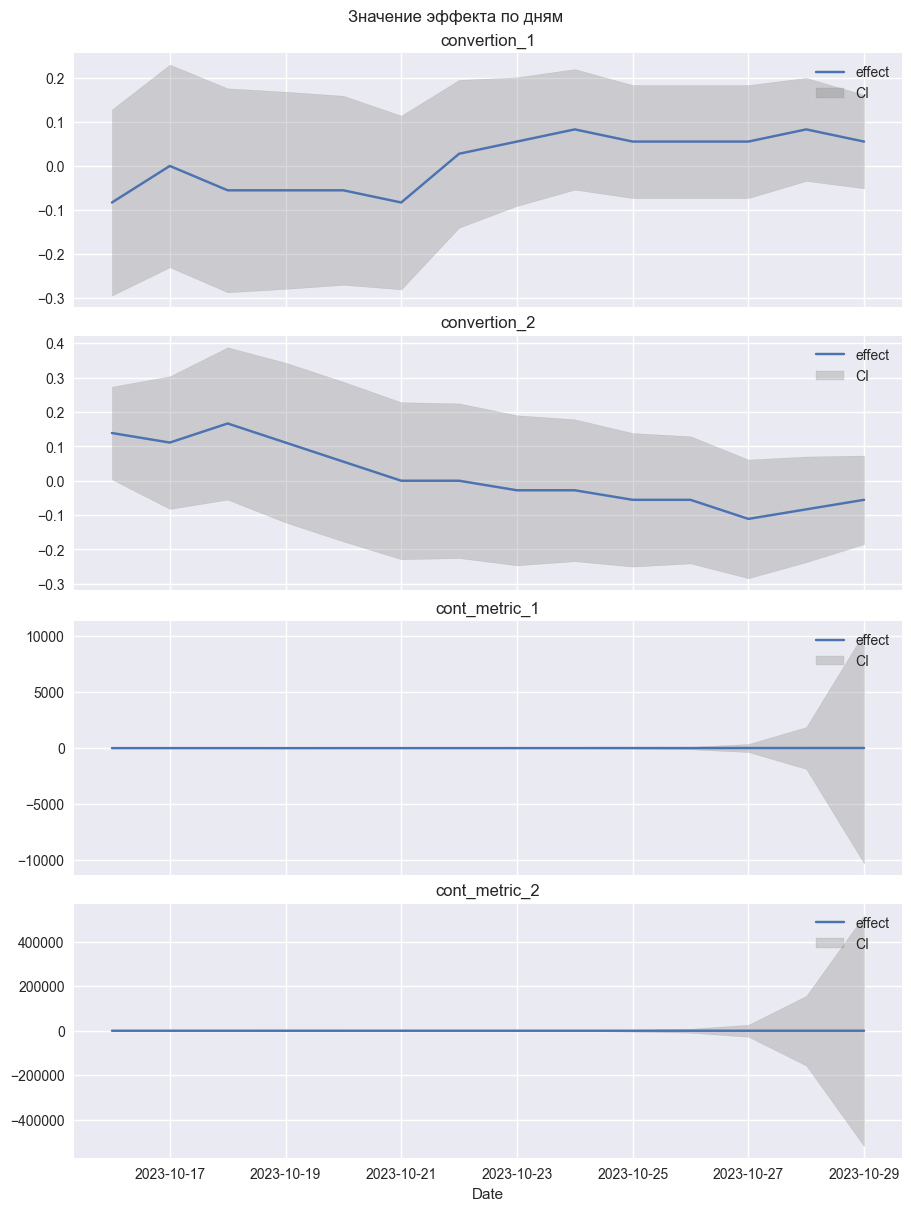

In [75]:
effects = calc_effect(
    dataset,
    'date',
    'group',
    'user_id',
    {
        'continuous': continuous_metrics,
        'binary': binary_metrics
    },
    {
        'first_type_errors': [0.05],
        'criterion': 'Т-тест'
    }
)

plot_effect(effects, 'date', [*binary_metrics, *continuous_metrics])

# Подведение результатов

In [117]:
test(
    dataframe=dataset,
    metrics=continuous_metrics,
    column_groups='group',
    group_labels=['A', 'B'],
    first_type_errors=[0.05],
    as_table=False
)

[{'first_type_error': 0.05,
  'pvalue': 1.0,
  'effect': -0.4907415822034835,
  'confidence_interval': (-3.1437, 2.1622),
  'metric name': 'cont_metric_1',
  'group A label': 'A',
  'group B label': 'B'},
 {'first_type_error': 0.05,
  'pvalue': 0.4634729668416092,
  'effect': -0.6035691136163805,
  'confidence_interval': (-1.7345, 0.5274),
  'metric name': 'cont_metric_2',
  'group A label': 'A',
  'group B label': 'B'}]

[1, 2, 3]

In [12]:
result = calc_test_results(
    dataset.groupby(['user_id', 'group'], as_index=False)[continuous_metrics].sum(),
    'group',
    {
        'continuous': continuous_metrics
    },
    {
        'first_type_errors': [0.05],
        'criterion': 'Т-тест'
    },
)

result

NameError: name 'calc_test_results' is not defined

In [122]:
pd.DataFrame(result)

,first_type_error,pvalue,effect,confidence_interval,metric name,group A label,group B label,mean in A,num in A,mean in B,num in B,is_success
0,0.05,0.481398,-11.335659,"(-288416.1838, 288393.5125)",cont_metric_1,A,B,288.182830,36,276.847171,36,False
1,0.05,0.134497,-18.168802,"(-36405.2419, 36368.9043)",cont_metric_2,A,B,620.736517,36,602.567715,36,False
